## Assignment 3: Detecting Spam

### Imports

Python imports:

In [53]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, TextVectorization
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

#### Data import

In [54]:
data = pd.read_csv('Spam_SMS.csv')
data

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


We have 5574 data entries, each having a message and a class (being either HAM or SPAM)

### Data Exploration

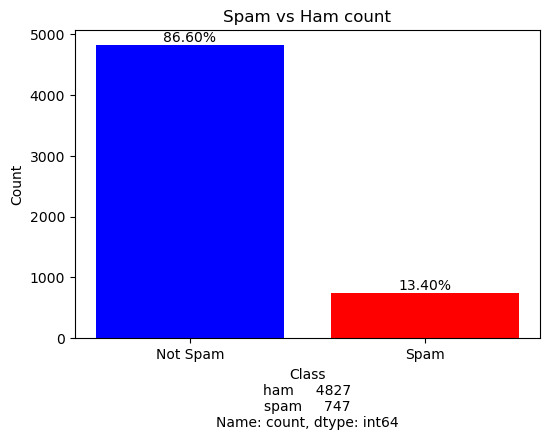

In [55]:
label_counts = data['Class'].value_counts()

# Get label counts as percentages
percentages = (label_counts / label_counts.sum()) * 100

# Plot percentages as figure
plt. figure(figsize=(6, 4))
bars = plt.bar(['Not Spam', 'Spam'], label_counts, color=['blue', 'red'])
for bar, percentage in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2, # X-coord = center ofthe bar
        bar.get_height(),
        f'{percentage:.2f}%', # Label with 2 decimal places
        ha = 'center',
        va = 'bottom'
    )

plt.title('Spam vs Ham count')
plt.ylabel('Count')
plt.xlabel(f'{label_counts}')
plt.show()


The data-set contains 4827 entries of ham (non-spam), and 747 entries that are spam. This corresponds to 86.6% and 13.4%, accordingly.

Before further exploration, all text is set to lowercase

In [56]:
def text_to_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(text_to_lowercase)

#### Most common words in HAM messages

In [57]:
# Frequency of words in HAM messages:

ham_words = ' '.join(data[data['Class'] == 'ham']['Message'])
ham_word_list = ham_words.split()
ham_word_count = Counter(ham_word_list)

# The 20 most common
most_common_ham = ham_word_count.most_common(20)
h_words, h_counts = zip(*most_common_ham)

Plotting the most common words in ham messages:

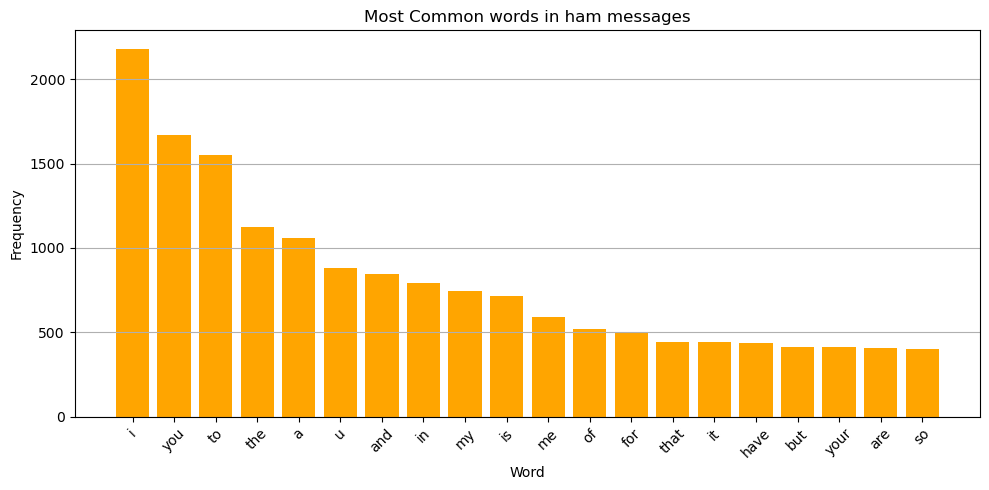

In [58]:
plt.figure(figsize=(10, 5))
plt.bar(h_words, h_counts, color='orange')
plt.title('Most Common words in ham messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-')
plt.tight_layout()

Lets plot the above as a WordCloud as well

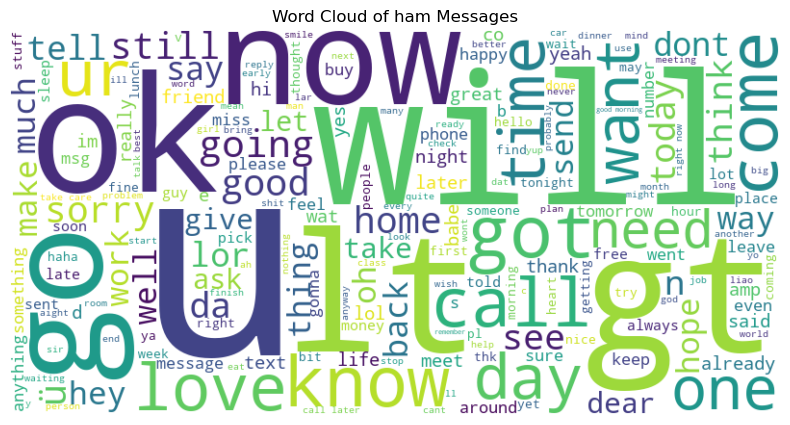

In [59]:
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of ham Messages')
plt.show()

#### Most common words in SPAM messages

In [60]:
# Frequency of words in SPAM messages:

spam_words = ' '.join(data[data['Class'] == 'spam']['Message'])
spam_word_list = spam_words.split()
spam_word_count = Counter(spam_word_list)

# The 20 most common
most_common_spam = spam_word_count.most_common(20)
s_words, s_counts = zip(*most_common_spam)

Plotting the most common words in spam messages:

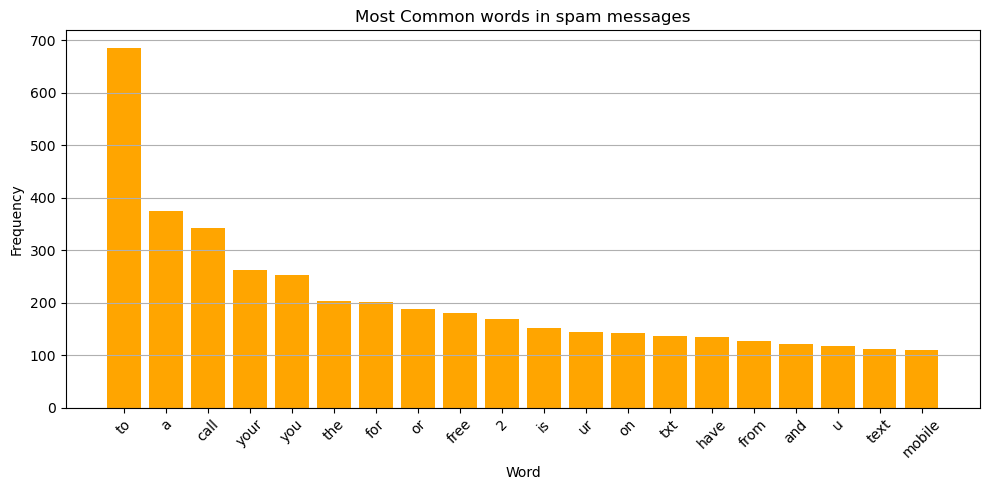

In [61]:
plt.figure(figsize=(10, 5))
plt.bar(s_words, s_counts, color='orange')
plt.title('Most Common words in spam messages')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='-')
plt.tight_layout()

Lets plot the above as a WordCloud as well

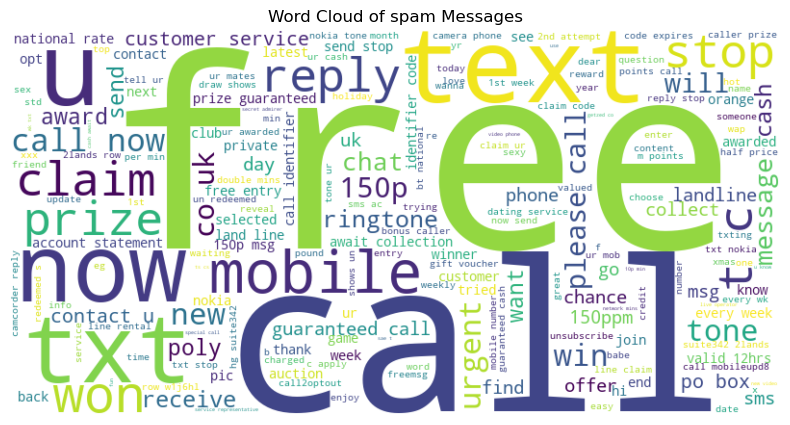

In [62]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of spam Messages')
plt.show()

Worth noting here, is that both ham and spam messages seem to contain "slang" language - such as "u" instead of "you" and such.

Another point is that, especially when looking at the WordCloud, the Spam messages seem to often contain some words that you would also expect from a spam message, such as "free" and "urgent".

### Preparation

The data is split up into X (data) and Y (class):

In [63]:
X = data.drop('Class', axis=1)
Y = data['Class']

#### Labelencoding

The Y dataset is encoded, so Spam=1 and ham =0

In [64]:
Y[:10]

0     ham
1     ham
2    spam
3     ham
4     ham
5    spam
6     ham
7     ham
8    spam
9    spam
Name: Class, dtype: object

In [65]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1])

#### Split the data

In [66]:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.2, random_state=42)

In [67]:
np.shape(X_train), np.shape(X_val), np.shape(X_test)

((3567, 1), (892, 1), (1115, 1))

#### Vectorization Configuration

In [68]:
max_tokens = 10000  # maximum number of unique tokens
max_len = 1000       # maximum sequence length after padding

##### Word-based:

In [69]:
word_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int', 
    output_sequence_length=max_len
    )
word_vectorizer.adapt(X_train)

##### Character-based:

In [70]:
char_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    split='character',
    output_mode='int',
    output_sequence_length=max_len
)
char_vectorizer.adapt(X_train)

### Model Definitions

#### LSTM with word embeddings

In [71]:
def create_lstm_model():
    model = Sequential([
        word_vectorizer,
        Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model

#### GRU with character embeddings

We are going to create and compare 2 models: LSTM and GRU. We will evaluate them on accuracy and precision - as it was decided that a high precision (meaning a lower number of ham messages being marked as spam) would be beneficial.
On the other hand, this might lead to some spam messages not getting classified as such.

In [72]:
def create_gru_model():
    model = Sequential([
        char_vectorizer,
        Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
        GRU(64),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    return model

In [73]:
def compile_model(model, adam_or_adamW):
    if adam_or_adamW == 'adamW':
        optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
    else:
        optimizer = 'adam'

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy', Precision(name='Precision')])
    return model

NOTE: The compile_model method takes an argument specifying wether it should compile with Adam or AdamW as optimizer-function.

#### Callbacks

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

#### Instantiate Models

In [75]:
lstm_model = compile_model(create_lstm_model(), 'adam')
gru_model = compile_model(create_lstm_model(), 'adam')

### Model Training

In [76]:
history_lstm = lstm_model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10


112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - Precision: 0.5791 - accuracy: 0.8725 - loss: 0.4211 - val_Precision: 0.8780 - val_accuracy: 0.9765 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - Precision: 0.9871 - accuracy: 0.9920 - loss: 0.0444 - val_Precision: 0.9123 - val_accuracy: 0.9776 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 347ms/step - Precision: 0.9968 - accuracy: 0.9983 - loss: 0.0108 - val_Precision: 0.9060 - val_accuracy: 0.9787 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 350ms/step - Precision: 0.9997 - accuracy: 0.9996 - loss: 0.0049 - val_Precision: 0.9292 - val_accuracy: 0.9809 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0022 - val_Precision: 0.9196 - val_accuracy: 0.9776 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 6/10
112/1

In [77]:
history_gru = gru_model.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 365ms/step - Precision: 0.6241 - accuracy: 0.8725 - loss: 0.4176 - val_Precision: 0.9623 - val_accuracy: 0.9821 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 350ms/step - Precision: 0.9911 - accuracy: 0.9920 - loss: 0.0378 - val_Precision: 0.9541 - val_accuracy: 0.9832 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - Precision: 0.9968 - accuracy: 0.9982 - loss: 0.0116 - val_Precision: 0.9375 - val_accuracy: 0.9821 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - Precision: 0.9949 - accuracy: 0.9981 - loss: 0.0076 - val_Precision: 0.8852 - val_accuracy: 0.9776 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - Precision: 1.0000 - accuracy: 1.0000 - loss: 0.0019 - val_Precision: 0.9217 - val_accuracy: 0.9809 - val_loss: 0.0605 - learning_rate: 0.0010
Epoch

#### Model Evaluation

In [78]:
lstm_results = lstm_model.evaluate(X_test, Y_test)
gru_results = gru_model.evaluate(X_test, Y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - Precision: 0.9928 - accuracy: 0.9910 - loss: 0.0313
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - Precision: 0.9726 - accuracy: 0.9908 - loss: 0.0352


Both models perform quite well on the test data, with the LSTM model performing marginally better.

#### Predictions

In [79]:
# Predictions for evaluation
lstm_preds = (lstm_model.predict(X_test) > 0.5).astype("int32")
gru_preds = (gru_model.predict(X_test) > 0.5).astype("int32")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step


#### Metrics

In [ ]:
print("LSTM Model Classification Report")
print(classification_report(Y_test, lstm_preds))
print("\nGRU Model Classification Report")
print(classification_report(Y_test, gru_preds))

LSTM Model Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       954
           1       0.99      0.91      0.95       161

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


GRU Model Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       954
           1       0.97      0.94      0.96       161

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



This shows that both models perform really well, with the GRU model having a bit higher recall for spam messages, meaning it is better at capturing spam.

### Plotting Results

In [81]:
def plot_training(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{title} accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

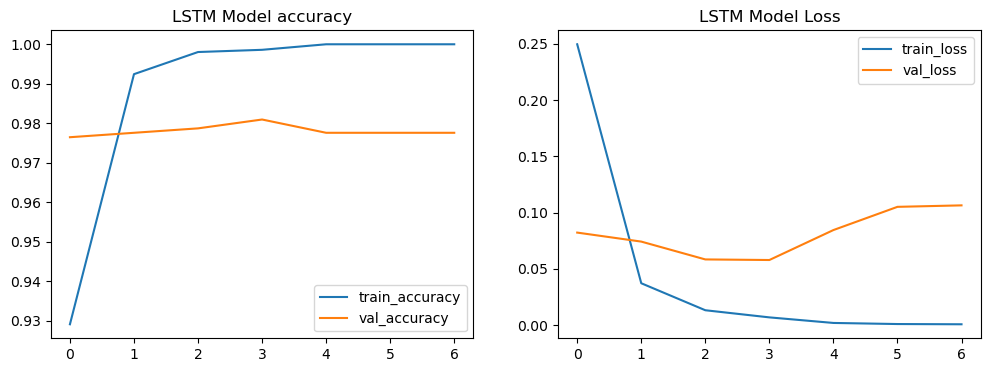

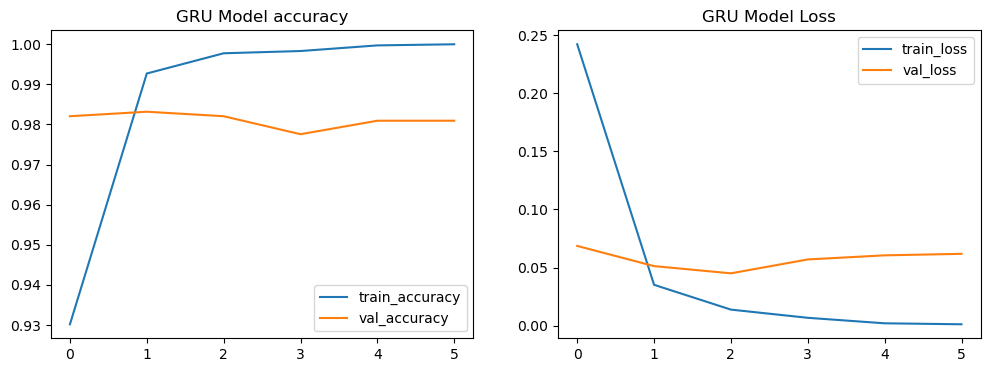

In [82]:
plot_training(history_lstm, "LSTM Model")
plot_training(history_gru, "GRU Model")

Let's try to use AdamW (with weight decay) as our optimizer instead of just Adam

In [83]:
lstm_model_adamW = compile_model(create_lstm_model(), 'adamW')
gru_model_adamW = compile_model(create_lstm_model(), 'adamW')

In [84]:
history_lstm_adamW = lstm_model_adamW.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 44s 358ms/step - Precision: 0.6132 - accuracy: 0.8800 - loss: 0.4145 - val_Precision: 0.9060 - val_accuracy: 0.9787 - val_loss: 0.0682 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - Precision: 0.9892 - accuracy: 0.9939 - loss: 0.0360 - val_Precision: 0.9537 - val_accuracy: 0.9821 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 343ms/step - Precision: 0.9997 - accuracy: 0.9957 - loss: 0.0177 - val_Precision: 0.9545 - val_accuracy: 0.9843 - val_loss: 0.0595 - learning_rate: 0.0010


In [85]:
history_gru_adamW = gru_model_adamW.fit(
    X_train, 
    Y_train, 
    epochs=10, 
    validation_data=(X_val, Y_val), 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 349ms/step - Precision: 0.4960 - accuracy: 0.8655 - loss: 0.4358 - val_Precision: 0.9292 - val_accuracy: 0.9809 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - Precision: 0.9784 - accuracy: 0.9930 - loss: 0.0373 - val_Precision: 0.9076 - val_accuracy: 0.9809 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 38s 340ms/step - Precision: 0.9997 - accuracy: 0.9983 - loss: 0.0114 - val_Precision: 0.9068 - val_accuracy: 0.9798 - val_loss: 0.0506 - learning_rate: 0.0010


In [86]:
lstm_results_adamW = lstm_model_adamW.evaluate(X_test, Y_test)
gru_results_adamW = gru_model_adamW.evaluate(X_test, Y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - Precision: 0.9531 - accuracy: 0.9860 - loss: 0.0503
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - Precision: 0.9745 - accuracy: 0.9888 - loss: 0.0552


In [ ]:
lstm_preds_adamW = (lstm_model_adamW.predict(X_test) > 0.5).astype("int32")
gru_preds_adamW = (gru_model_adamW.predict(X_test) > 0.5).astype("int32")

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step


In [ ]:
print("LSTM Model Classification Report (AdamW)")
print(classification_report(Y_test, lstm_preds_adamW, target_names=['Ham', 'Spam']))
print("\nGRU Model Classification Report (AdamW)")
print(classification_report(Y_test, gru_preds_adamW, target_names=['Ham', 'Spam']))

LSTM Model Classification Report (AdamW)
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       954
        Spam       0.97      0.93      0.95       161

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115


GRU Model Classification Report (AdamW)
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       954
        Spam       0.97      0.93      0.95       161

    accuracy                           0.98      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



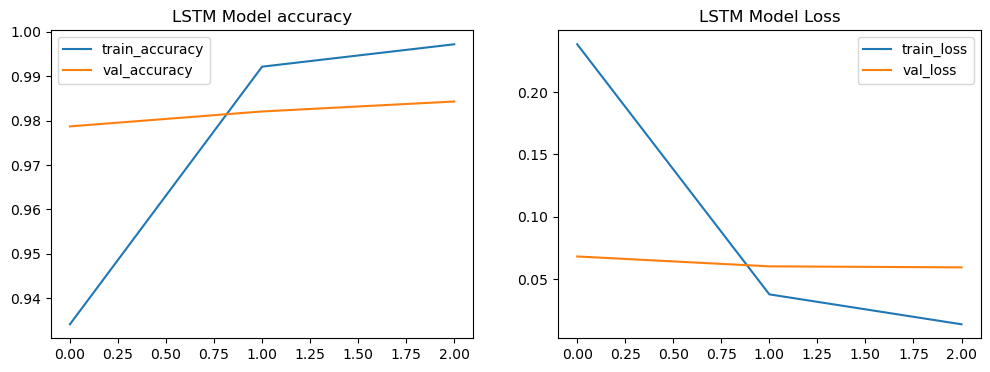

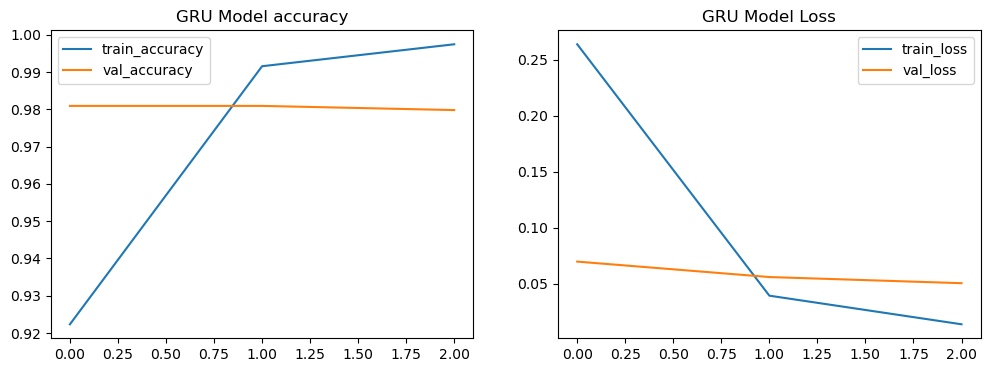

In [89]:
plot_training(history_lstm_adamW, "LSTM Model")
plot_training(history_gru_adamW, "GRU Model")

### Confusion Matrix

In [90]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentages
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix (%): {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


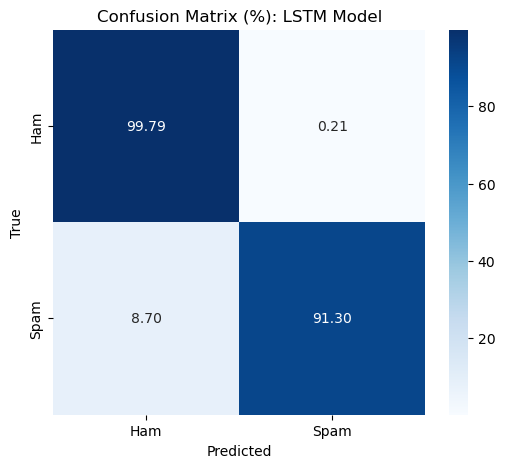

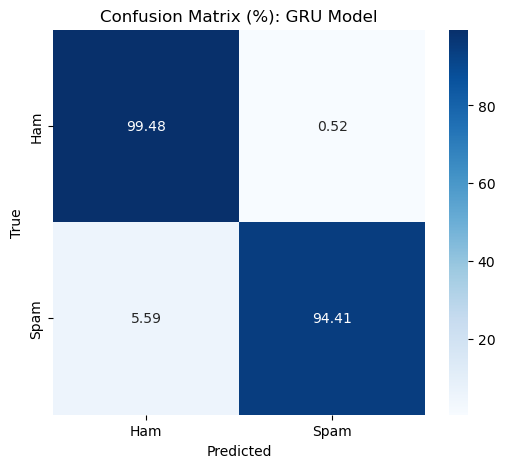

In [91]:
plot_confusion_matrix(Y_test, lstm_preds, "LSTM Model")
plot_confusion_matrix(Y_test, gru_preds, "GRU Model")

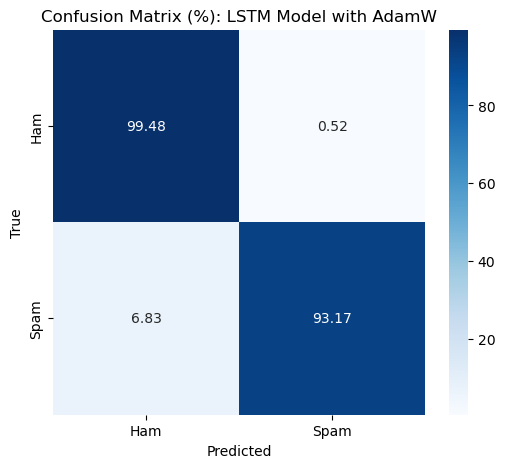

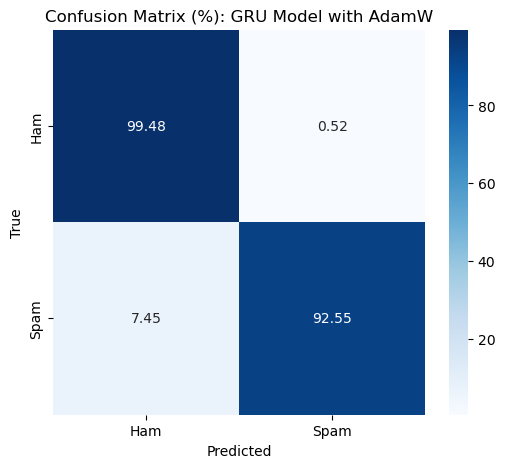

In [92]:
plot_confusion_matrix(Y_test, lstm_preds_adamW, "LSTM Model with AdamW")
plot_confusion_matrix(Y_test, gru_preds_adamW, "GRU Model with AdamW")

In [ ]:
results = {
    'Model': [
        'LSTM with AdamW', 'GRU with AdamW', 
        'LSTM without AdamW', 'GRU without AdamW'
    ],
    'Accuracy': [
        accuracy_score(Y_test, lstm_preds_adamW), 
        accuracy_score(Y_test, gru_preds_adamW),
        accuracy_score(Y_test, lstm_preds),
        accuracy_score(Y_test, gru_preds)
    ],
    'F1 Score': [
        f1_score(Y_test, lstm_preds_adamW), 
        f1_score(Y_test, gru_preds_adamW),
        f1_score(Y_test, lstm_preds),
        f1_score(Y_test, gru_preds)
    ],
    'Precision': [
        precision_score(Y_test, lstm_preds_adamW), 
        precision_score(Y_test, gru_preds_adamW),
        precision_score(Y_test, lstm_preds),
        precision_score(Y_test, gru_preds)
    ],
    'Recall': [
        recall_score(Y_test, lstm_preds_adamW), 
        recall_score(Y_test, gru_preds_adamW),
        recall_score(Y_test, lstm_preds),
        recall_score(Y_test, gru_preds)
    ]
}

# Create DataFrame and display
results_df = pd.DataFrame(results)
print("Model Comparison Summary:")
print(results_df)

Model Comparison Summary:
                Model  Accuracy  F1 Score  Precision    Recall
0     LSTM with AdamW  0.985650  0.949367   0.967742  0.931677
1      GRU with AdamW  0.984753  0.946032   0.967532  0.925466
2  LSTM without AdamW  0.985650  0.948387   0.986577  0.913043
3   GRU without AdamW  0.987444  0.955975   0.968153  0.944099


Comparing the models, it seems that using AdamW is not beneficial for this specific task (although it does not seem to hurt the results much, either.)

Overall, all models perfor extraordinarilly well, with the 2 models using Adam standing out as the "best" models, depending on the focus:

- If spam detection is the most critical priority, the GRU model without AdamW is the preferred choice, with it having the highest F1-score and recall.

- If avoiding false positives (ham being classified as spam) is the most critical priority, then the LSTM model without AdamW is the best model, as it has the highest precision.